In [ ]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch, random
import torch.nn as nn
import torch.nn.functional as F
import pennylane as qml
from torch.utils.data import DataLoader, TensorDataset

# ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
# sys.path.append(ROOT_DIR)

num_subjects = 18
num_classes = 10
num_trials = 3
num_channels = 2
num_ensembles = 10

seed = 42

In [ ]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
x = np.load('data/x.npy')
y = np.load('data/y.npy')
px = np.load('data/px.npy')
orig_x = np.load('data/origx.npy')
nPoints = np.load('data/nPoints.npy')

x_tensor = torch.tensor(px, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [ ]:
n_qubits = 4

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=4):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y

class Model(nn.Module):
    def __init__(self, input_len, input_channels, num_classes):
        super().__init__()
        self.n_class = num_classes

        self.conv1 = nn.ModuleList([nn.Conv1d(input_channels, 8, k, padding='same') for k in [1, 3, 5, 7]])
        self.se1 = SEBlock(32)
        self.pool1 = nn.AvgPool1d(3, stride=3)

        self.conv2 = nn.ModuleList([nn.Conv1d(32, 16, k, padding='same') for k in [1, 3, 5, 7]])
        self.se2 = SEBlock(64)
        self.pool2 = nn.MaxPool1d(3, stride=3)

        self.conv3 = nn.ModuleList([nn.Conv1d(64, 32, k, padding='same') for k in [1, 3, 5, 7]])
        self.se3 = SEBlock(128)
        self.pool3 = nn.MaxPool1d(3, stride=3)

        self.conv4 = nn.ModuleList([nn.Conv1d(128, 32, k, padding='same') for k in [1, 3, 5, 7]])
        self.pool4 = nn.AvgPool1d(2, stride=2)

        self.project_to_q = nn.Sequential(
            nn.Conv1d(128, n_qubits, kernel_size=1),
            nn.BatchNorm1d(n_qubits),
            nn.Tanh()
        )

        self.wires = list(range(n_qubits))
        self.dev = qml.device("default.qubit", wires=self.wires)

        def VQC(inputs, weights):
            qml.AngleEmbedding(inputs, wires=self.wires, rotation="Y")
            qml.CRX(weights[0, 3, 2], wires=[3, 0])
            qml.CRX(weights[0, 2, 2], wires=[2, 3])
            qml.CRX(weights[0, 1, 2], wires=[1, 2])
            qml.CRX(weights[0, 0, 2], wires=[0, 1])
            qml.RY(weights[0, 0, 4], wires=0)
            qml.RY(weights[0, 1, 4], wires=1)
            qml.RY(weights[0, 2, 4], wires=2)
            qml.RY(weights[0, 3, 4], wires=3)
            qml.CRX(weights[0, 3, 2], wires=[3, 2])
            qml.CRX(weights[0, 2, 2], wires=[2, 3])
            qml.CRX(weights[0, 1, 2], wires=[1, 0])
            qml.CRX(weights[0, 2, 3], wires=[2, 1])
            return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

        self.weight_shapes = {"weights": (1, n_qubits, 5)}
        self.qnode = qml.QNode(VQC, self.dev, interface="torch")
        self.vqc_layer = qml.qnn.TorchLayer(self.qnode, self.weight_shapes)

        dummy = torch.zeros(1, input_channels, input_len)
        with torch.no_grad():
            x = self._forward_conv(dummy)
            x = self.project_to_q(x)
            self.seq_len = x.shape[2]

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(n_qubits * self.seq_len, num_classes)

    def _forward_conv(self, x):
        x = torch.cat([F.relu(conv(x)) for conv in self.conv1], dim=1)
        x = self.se1(x)
        x = self.pool1(x)
        x = torch.cat([F.relu(conv(x)) for conv in self.conv2], dim=1)
        x = self.se2(x)
        x = self.pool2(x)
        x = torch.cat([F.relu(conv(x)) for conv in self.conv3], dim=1)
        x = self.se3(x)
        x = self.pool3(x)
        x = torch.cat([F.relu(conv(x)) for conv in self.conv4], dim=1)
        x = self.pool4(x)
        return x

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self._forward_conv(x)
        x = self.project_to_q(x)
        x = x.permute(0, 2, 1)
        B, S, Q = x.shape
        x = x.reshape(B * S, Q)
        x = self.vqc_layer(x)
        x = x.reshape(B, S, Q)
        x = x.flatten(start_dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cm = np.zeros([num_subjects, num_trials, num_classes, num_classes], dtype=int)
cm_merged = np.zeros([num_classes, num_classes], dtype=int)

for s_id in range(0, num_subjects):
    print('------------------------------------------------------------\n')
    print(f'{s_id}/{num_subjects} Training / Testing Validation')
    print('------------------------------------------------------------\n')

    idx_test = np.arange(s_id * num_trials * num_classes, (s_id + 1) * num_trials * num_classes)
    bTrain = np.ones(x.shape[0], dtype=bool)
    bTrain[idx_test] = False

    x_train_xy = torch.tensor(px[bTrain], dtype=torch.float32).to(device)
    x_test_xy = torch.tensor(px[idx_test], dtype=torch.float32).to(device)
    y_train = torch.tensor(y[bTrain], dtype=torch.long).to(device)
    y_test = torch.tensor(y[idx_test], dtype=torch.long).to(device)

    train_dataset = TensorDataset(x_train_xy, y_train)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    model_xy_orig = []
    preds_iter = []

    for i in range(10):
        model = Model(
            x.shape[1],
            input_channels=num_channels,
            num_classes=num_classes
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

        model.train()
        for epoch in range(200):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = model(xb)
                loss = F.cross_entropy(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()  # update LR

        model.eval()
        with torch.no_grad():
            preds = model(x_test_xy)
            preds_iter.append(preds.cpu().numpy())
            acc = (preds.argmax(dim=1) == y_test).float().mean().item()
            print(f'Test Acc ({i}): {acc:.4f}')

    preds_iter = np.stack(preds_iter, axis=-1)
    preds_median = np.median(preds_iter, axis=-1)
    pred_labels = np.argmax(preds_median, axis=1)
    true_labels = y_test.cpu().numpy()

    cnt = 0
    for j in range(num_trials):
        for k in range(num_classes):
            cm[s_id, j, true_labels[cnt], pred_labels[cnt]] += 1
            cnt += 1

    acc_median = np.mean(pred_labels == true_labels)
    print(f'Test Acc (median): {acc_median:.4f}')
    print('-----------------------------------')

cm_merged = cm.sum(axis=0).sum(axis=0)


------------------------------------------------------------

0/18 Training / Testing Validation
------------------------------------------------------------

Test Acc (0): 0.9000
Test Acc (1): 0.9333
Test Acc (2): 0.9000
Test Acc (3): 0.8667
Test Acc (4): 0.9667
Test Acc (5): 0.9000
Test Acc (6): 0.9667
Test Acc (7): 0.9667
Test Acc (8): 0.9333
Test Acc (9): 0.8667
Test Acc (median): 1.0000
-----------------------------------
------------------------------------------------------------

1/18 Training / Testing Validation
------------------------------------------------------------

Test Acc (0): 0.8333
Test Acc (1): 1.0000
Test Acc (2): 0.8333
Test Acc (3): 0.9333
Test Acc (4): 0.9667
Test Acc (5): 0.8333
Test Acc (6): 0.9000
Test Acc (7): 0.8667
Test Acc (8): 0.9333
Test Acc (9): 0.9000
Test Acc (median): 0.9667
-----------------------------------
------------------------------------------------------------

2/18 Training / Testing Validation
-----------------------------------------

In [6]:
cm.sum(0).sum(1)

array([[18, 17, 20, 17, 19, 18, 19, 17, 17, 18],
       [18, 18, 18, 17, 18, 19, 18, 18, 18, 18],
       [18, 17, 18, 17, 19, 19, 18, 18, 18, 18]])

In [7]:
#model_xy_orig[i].summary()

In [8]:
#from keras.utils.vis_utils import model_to_dot
#%matplotlib inline
#model_to_dot(model_xy_orig[i])

In [9]:
#from keras.utils import plot_model
#plot_model(model_xy_orig[i], to_file='model.png')

In [10]:
#error 발생시킨 패턴 체크
error_list = np.zeros([int(cm_merged.sum() - np.diag(cm_merged).sum()),4])
cnt_e = 0
for i in range(0,num_subjects):
    for j in range(0, num_trials):
        for k in range(0, num_classes):
            for l in range(0, num_classes):
                if cm[i,j,k,l]>0 and k!=l:
                    error_list[cnt_e,:] = [i,j,k,l]
                    cnt_e += 1

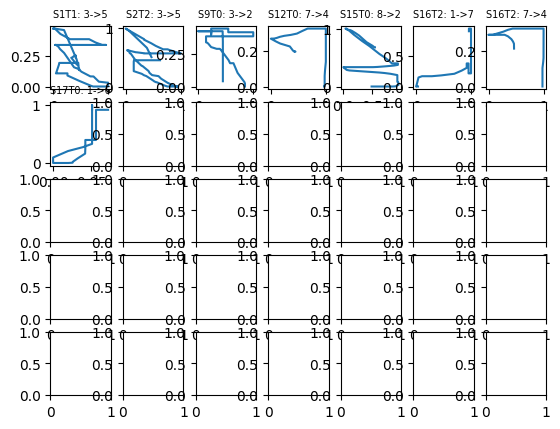

In [11]:
w = 7
h = 5
fig, axs = plt.subplots(h, w)
cnt = 0
for i in range(0,h):
    for j in range(0,w):
        if cnt>=error_list.shape[0]:
            break
        idx = int(error_list[cnt,0]*num_trials*num_classes + error_list[cnt,1]* num_classes +error_list[cnt,2])
        axs[i, j].plot(px[idx,:,0], px[idx,:,1])
        axs[i, j].set_title(f'S{int(error_list[cnt,0])}T{int(error_list[cnt,1])}: {int(error_list[cnt,2])}->{int(error_list[cnt,3])}', fontsize= 7)
        cnt += 1
fig.show()

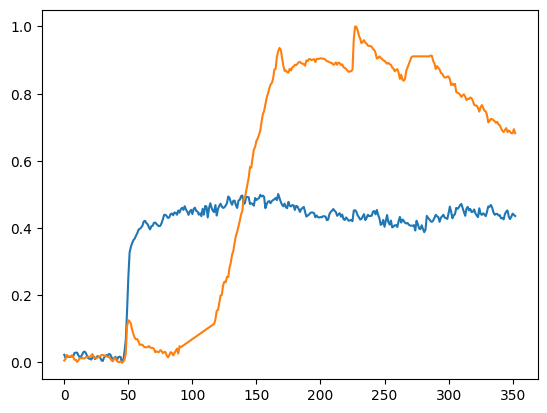

In [13]:
idx = int(11*num_trials*num_classes + 0* num_classes +1)
plt.plot(x[idx,:,0])
plt.plot(x[idx,:,1])
plt.show()

In [14]:
cm_merged

array([[54,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 52,  0,  0,  0,  0,  1,  1,  0,  0],
       [ 0,  0, 54,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 51,  0,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 54,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 54,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 54,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0, 52,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0, 53,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 54]])

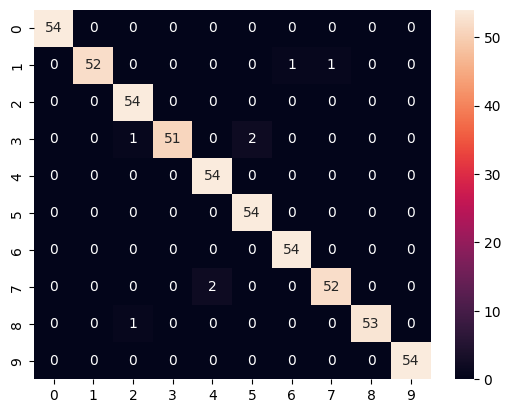

In [15]:
cm_merged_df = pd.DataFrame(cm_merged)

sns.heatmap(cm_merged_df, annot=True)
plt.show()

In [16]:
acc = np.diag(cm_merged).sum()*100/cm_merged.sum()
print(f'Final Accuracy= {acc}%\n')

Final Accuracy= 98.51851851851852%



In [17]:
cm.shape

(18, 3, 10, 10)

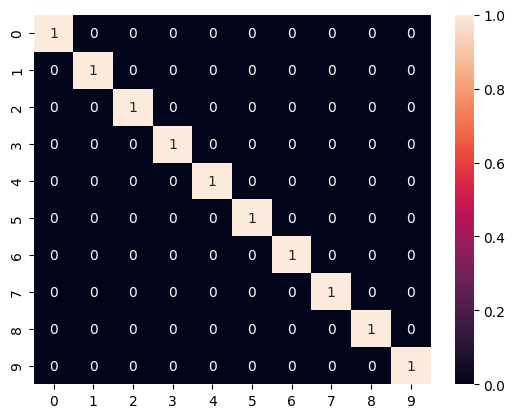

In [18]:
cm_merged_df = pd.DataFrame(cm[1, 0])

sns.heatmap(cm_merged_df, annot=True)
plt.show()

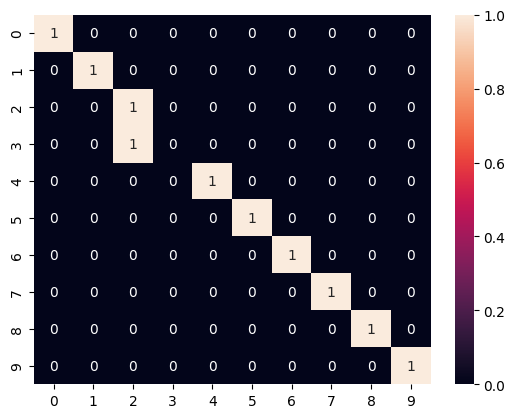

In [19]:
cm_merged_df = pd.DataFrame(cm[9, 0])

sns.heatmap(cm_merged_df, annot=True)
plt.show()

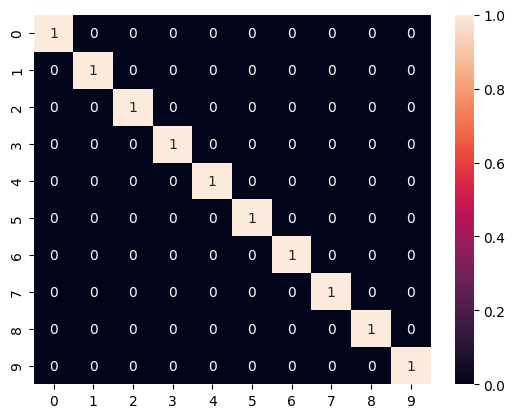

In [20]:
cm_merged_df = pd.DataFrame(cm[9, 1])

sns.heatmap(cm_merged_df, annot=True)
plt.show()

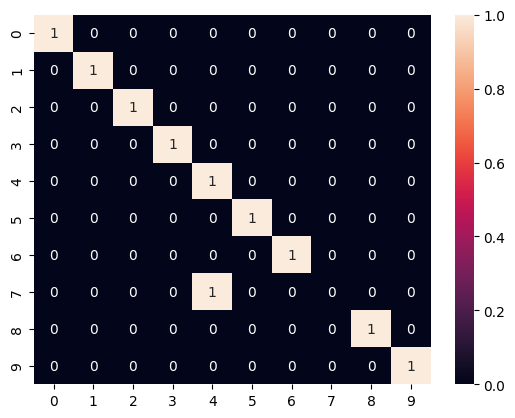

In [21]:
cm_merged_df = pd.DataFrame(cm[12, 0])

sns.heatmap(cm_merged_df, annot=True)
plt.show()

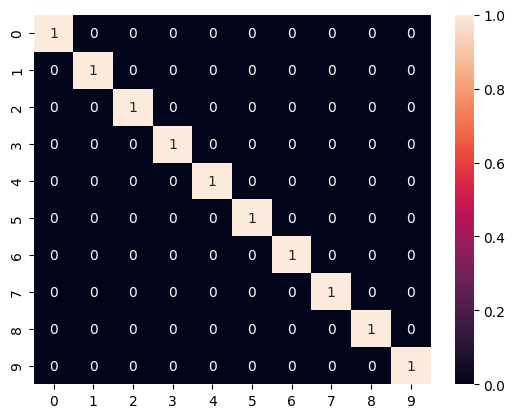

In [22]:
cm_merged_df = pd.DataFrame(cm[12, 1])

sns.heatmap(cm_merged_df, annot=True)
plt.show()

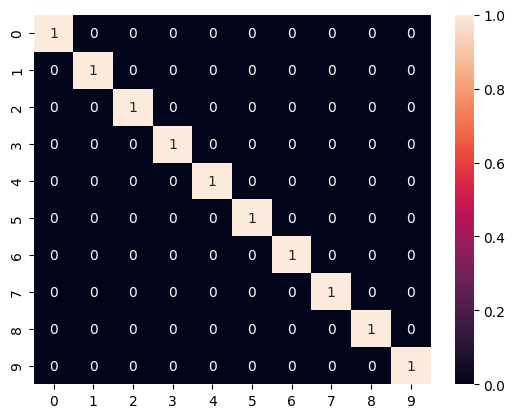

In [23]:
cm_merged_df = pd.DataFrame(cm[13, 0])

sns.heatmap(cm_merged_df, annot=True)
plt.show()

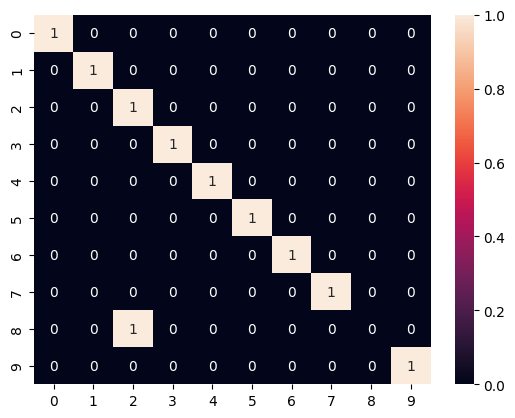

In [24]:
cm_merged_df = pd.DataFrame(cm[15, 0])

sns.heatmap(cm_merged_df, annot=True)
plt.show()

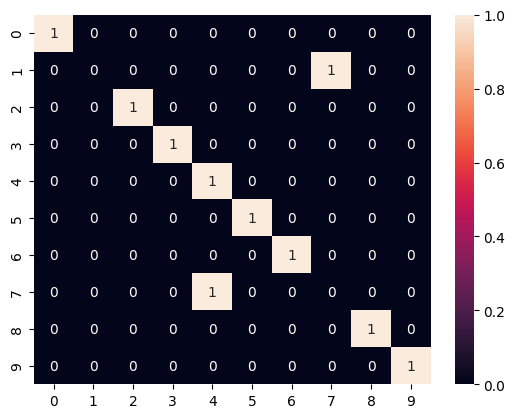

In [25]:
cm_merged_df = pd.DataFrame(cm[16, 2])

sns.heatmap(cm_merged_df, annot=True)
plt.show()

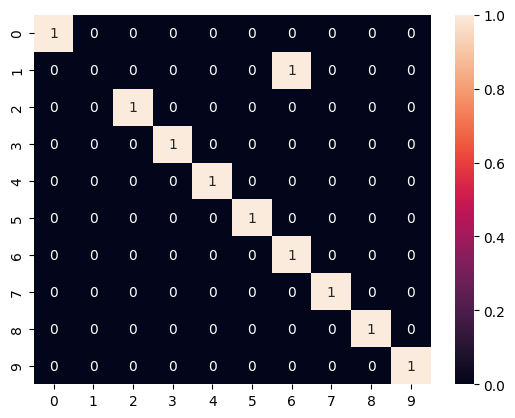

In [26]:
cm_merged_df = pd.DataFrame(cm[17, 0])

sns.heatmap(cm_merged_df, annot=True)
plt.show()